In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

## Load data and explore

In [59]:
df = pd.read_csv('lending-club-data.csv', low_memory=False)

In [61]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [63]:
features = ['grade', 'sub_grade', 'short_emp', 'emp_length_num', 'home_ownership', 
    'dti', 'purpose', 'term', 'last_delinq_none', 'last_major_derog_none', 
    'revol_util', 'total_rec_late_fee']
df2 = df[features].dropna()
df2.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.00
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00


In [65]:
df2['short_emp'] = df2['short_emp'].astype(np.int8)
df2['last_delinq_none'] = df2['last_delinq_none'].astype(np.int8)
df2['last_major_derog_none'] = df2['last_major_derog_none'].astype(np.int8)

In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   grade                  122607 non-null  object 
 1   sub_grade              122607 non-null  object 
 2   short_emp              122607 non-null  int8   
 3   emp_length_num         122607 non-null  int64  
 4   home_ownership         122607 non-null  object 
 5   dti                    122607 non-null  float64
 6   purpose                122607 non-null  object 
 7   term                   122607 non-null  object 
 8   last_delinq_none       122607 non-null  int8   
 9   last_major_derog_none  122607 non-null  int8   
 10  revol_util             122607 non-null  float64
 11  total_rec_late_fee     122607 non-null  float64
dtypes: float64(3), int64(1), int8(3), object(5)
memory usage: 8.8+ MB


In [69]:
loan_counts = df['bad_loans'].value_counts(normalize=True) * 100

print(f"Safe Loans (0): {loan_counts.get(0, 0):.2f}%")
print(f"Risky Loans (1): {loan_counts.get(1, 0):.2f}%")

Safe Loans (0): 81.12%
Risky Loans (1): 18.88%


## Sample data to balance classes

In [71]:
safe_loans_raw = df[df['bad_loans'] == 0]
risky_loans_raw = df[df['bad_loans'] == 1]

In [73]:
# Since there are fewer risky loans than safe loans, find the ratio of the sizes and use that percentage to undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(frac = percentage, random_state = 1)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = pd.concat([risky_loans, safe_loans], ignore_index=True)
loans_data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
1,1071795,1306957,5600,5600,5600,60 months,21.28,152.39,F,F2,...,0.4,1.0,1.0,1.0,0,4.57170,20161201T000000,1,1,1
2,1071570,1306721,5375,5375,5350,60 months,12.69,121.45,B,B5,...,1.0,1.0,1.0,1.0,1,9.71600,20161201T000000,1,1,1
3,1064687,1298717,9000,9000,9000,36 months,13.49,305.38,C,C1,...,0.2,1.0,1.0,1.0,1,12.21520,20141201T000000,1,1,1
4,1069057,1303503,10000,10000,10000,36 months,10.65,325.74,B,B2,...,0.4,1.0,1.0,1.0,0,3.90888,20141201T000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46295,808056,1014698,1775,1775,1775,36 months,7.49,55.21,A,A4,...,0.8,1.0,0.0,1.0,0,1.20458,20140701T000000,1,0,1
46296,5790590,7222513,6000,6000,6000,36 months,10.16,194.06,B,B1,...,0.2,1.0,1.0,1.0,0,6.12821,20160601T000000,1,1,1
46297,1431918,1683248,6000,6000,6000,36 months,10.16,194.06,B,B1,...,0.2,1.0,1.0,1.0,0,11.64360,20150801T000000,1,1,1
46298,13127242,15149422,14975,14975,14975,60 months,25.57,444.56,F,F5,...,1.0,1.0,1.0,1.0,0,10.66940,20190401T000000,0,1,0


In [75]:
loan_counts2 = loans_data['bad_loans'].value_counts(normalize=True) * 100

print(f"Percentage of Safe Loans (0): {loan_counts2.get(0, 0):.2f}%")
print(f"Percentage of Risky Loans (1): {loan_counts2.get(1, 0):.2f}%")

Percentage of Safe Loans (0): 50.00%
Percentage of Risky Loans (1): 50.00%


In [77]:
X=loans_data[features]
y=loans_data['bad_loans']


## Splitting the data

In [79]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=loans_data['bad_loans'])
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0, stratify= y_trainval)

## One Hot Encoding

In [81]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

In [83]:
#encoding for decision tree
categorical_cols = ['grade', 'sub_grade', 'home_ownership', 'purpose', 'term','short_emp','last_delinq_none','last_major_derog_none']
num_cols= [x for x in features if x not in categorical_cols]
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_er = encoder.fit_transform(X_train[categorical_cols])
X_val_er = encoder.transform(X_val[categorical_cols])
X_test_er = encoder.transform(X_test[categorical_cols])

#combining with num columns 
X_train_num = sparse.csr_matrix(X_train.drop(columns=categorical_cols).values)
X_val_num = sparse.csr_matrix(X_val.drop(columns=categorical_cols).values)
X_test_num = sparse.csr_matrix(X_test.drop(columns=categorical_cols).values)
X_train_en = sparse.hstack((X_train_er, X_train_num))
X_val_en = sparse.hstack((X_val_er, X_val_num))
X_test_en = sparse.hstack((X_test_er, X_test_num))



## Build decision tree

In [85]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree

In [87]:
num_features = X_train.drop(columns=categorical_cols).columns.tolist()
cat_features = encoder.get_feature_names_out(categorical_cols).tolist()
feature_names = cat_features + num_features
feature_names

['grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'sub_grade_A2',
 'sub_grade_A3',
 'sub_grade_A4',
 'sub_grade_A5',
 'sub_grade_B1',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C1',
 'sub_grade_C2',
 'sub_grade_C3',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D1',
 'sub_grade_D2',
 'sub_grade_D3',
 'sub_grade_D4',
 'sub_grade_D5',
 'sub_grade_E1',
 'sub_grade_E2',
 'sub_grade_E3',
 'sub_grade_E4',
 'sub_grade_E5',
 'sub_grade_F1',
 'sub_grade_F2',
 'sub_grade_F3',
 'sub_grade_F4',
 'sub_grade_F5',
 'sub_grade_G1',
 'sub_grade_G2',
 'sub_grade_G3',
 'sub_grade_G4',
 'sub_grade_G5',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'sh

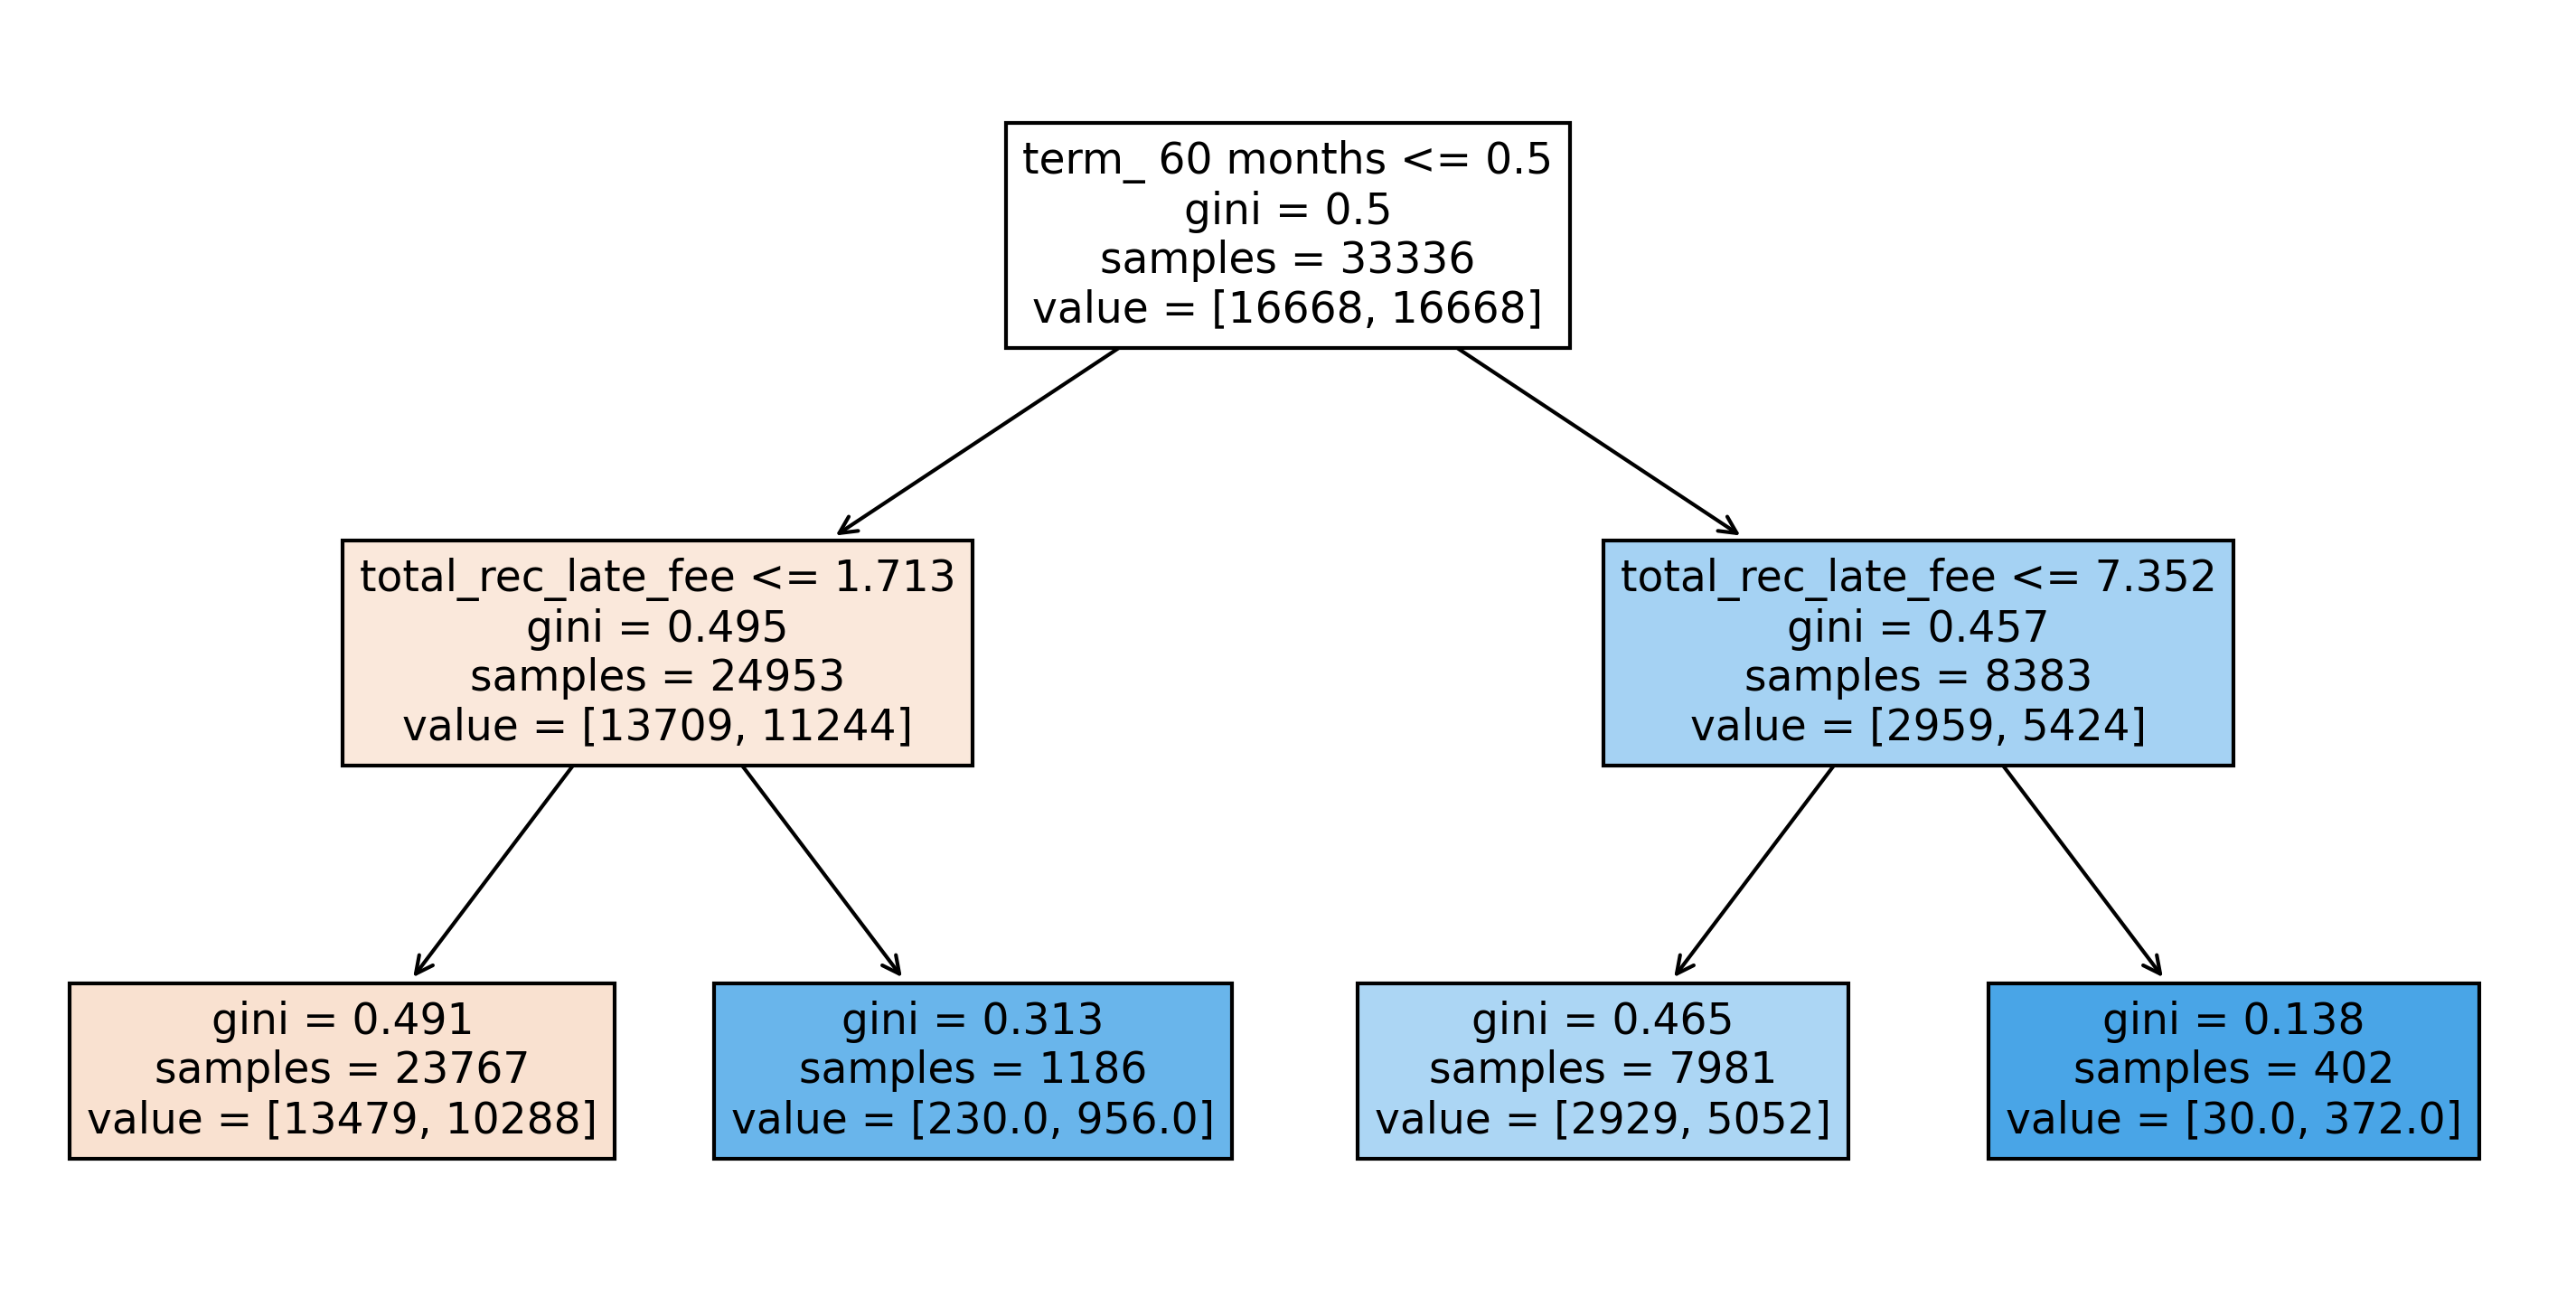

In [89]:
tree1 = DecisionTreeClassifier(max_depth=2)
tree1.fit(X_train_en, y_train)
plt.figure(figsize=(12, 6), dpi=300)
tree_dot1 = plot_tree(tree1, feature_names=feature_names, filled=True)

In [91]:
from sklearn.metrics import accuracy_score
pred = tree1.predict(X_val_en)
acc = accuracy_score(y_val, pred)
acc

0.5874730021598272

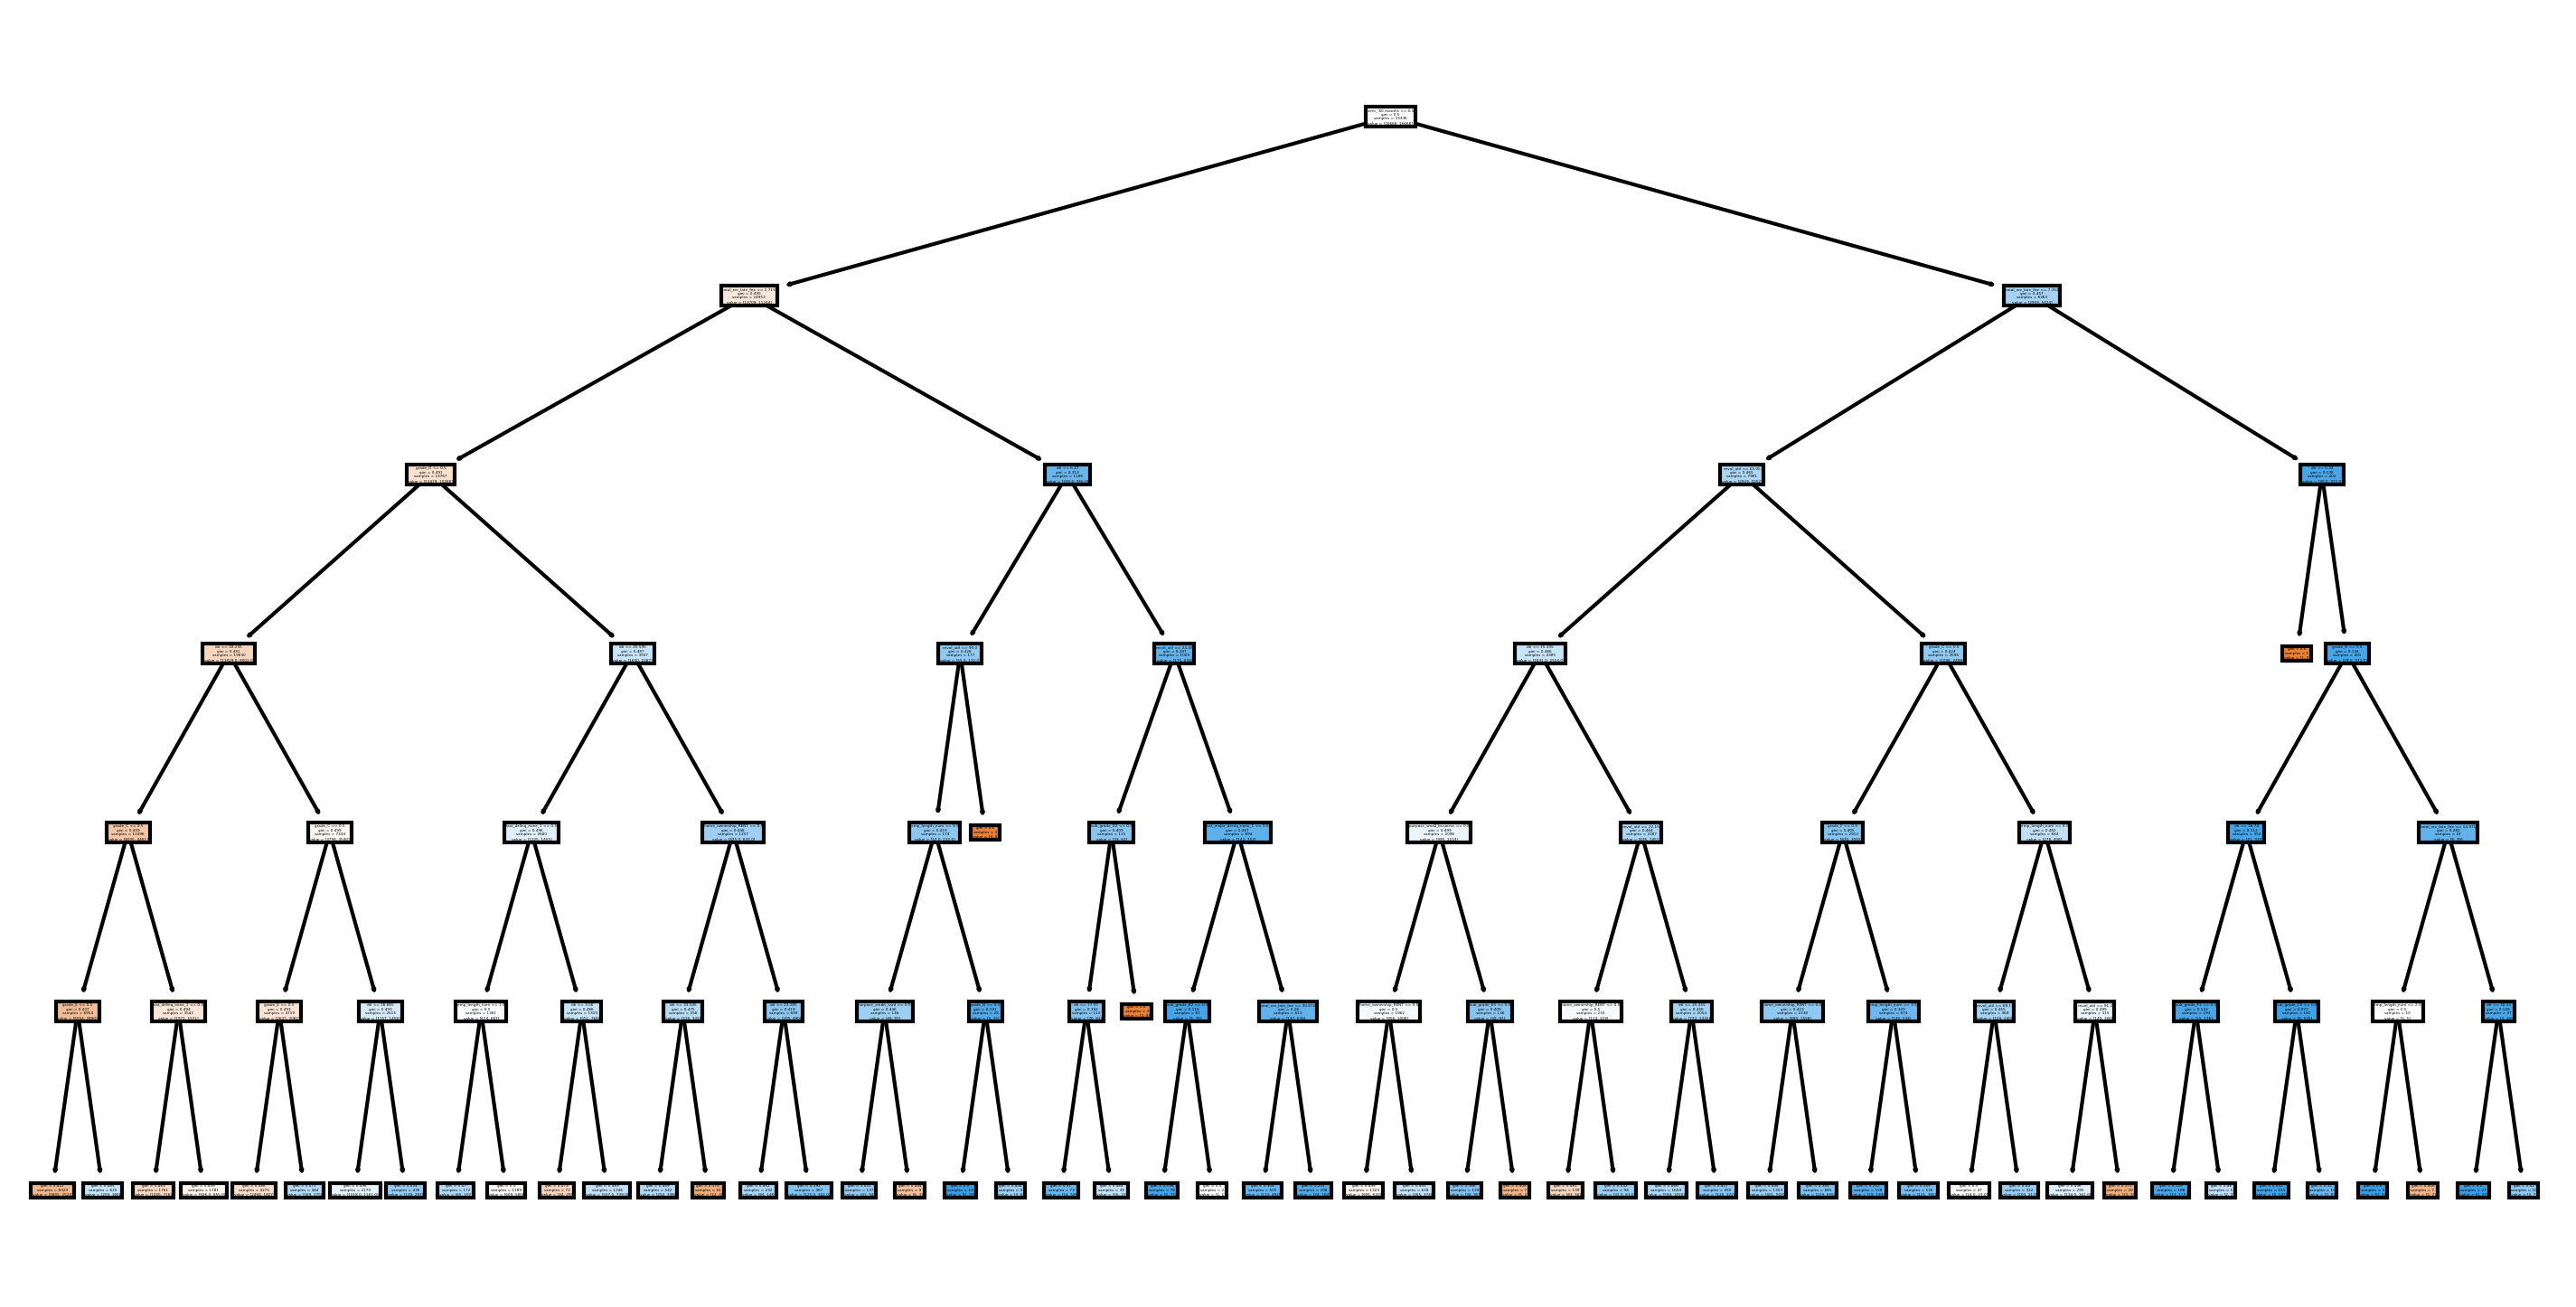

In [93]:
tree2 = DecisionTreeClassifier(max_depth=6)
tree2.fit(X_train_en, y_train)
plt.figure(figsize=(12, 6), dpi=300)
tree_dot2 = plot_tree(tree2, feature_names=feature_names, filled=True)

In [95]:
pred2 = tree2.predict(X_val_en)
acc2 = accuracy_score(y_val, pred2)
acc2

0.6216702663786897

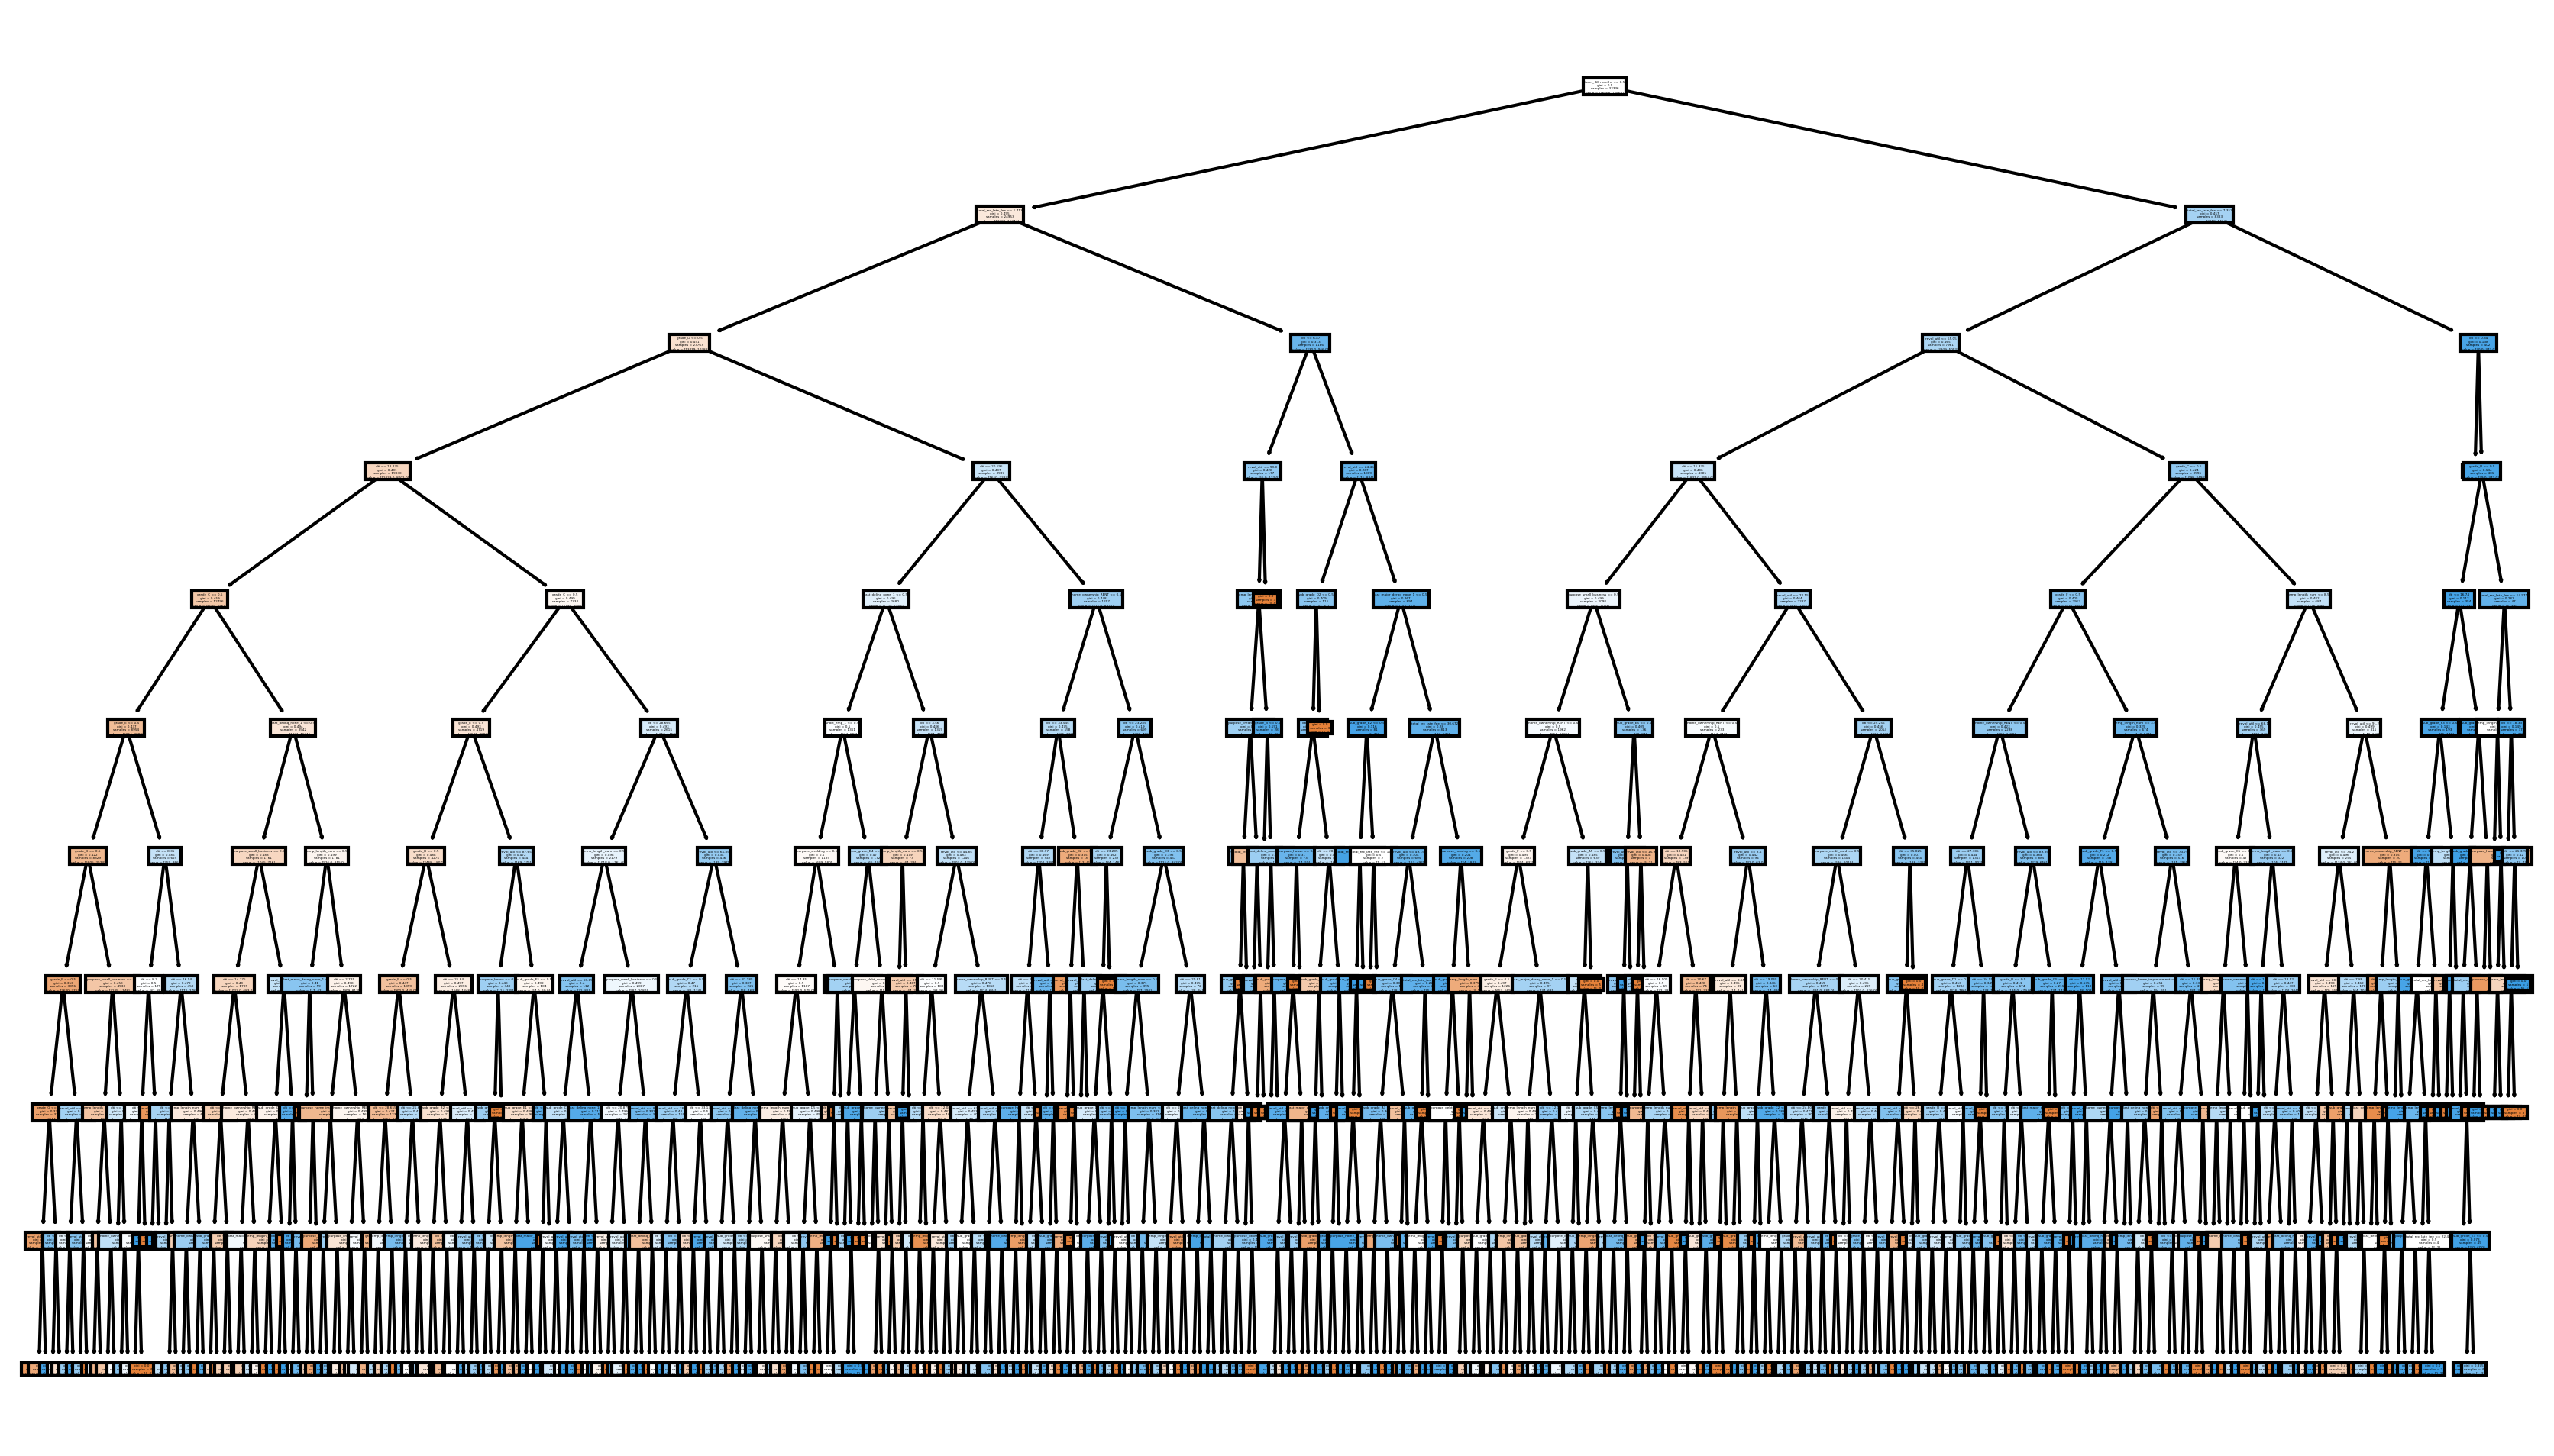

In [97]:
tree3 = DecisionTreeClassifier(max_depth=10)
tree3.fit(X_train_en, y_train)
plt.figure(figsize=(14, 8), dpi=300)
tree_dot3 = plot_tree(tree3, feature_names=feature_names, filled=True)

In [99]:
pred3 = tree3.predict(X_val_en)
acc3 = accuracy_score(y_val, pred3)
acc3

0.6183105351571875

In [101]:
#using best model (tree 3) on test set
y_test_pred = tree3.predict(X_test_en)
acc4 = accuracy_score(y_test, y_test_pred)
acc4

0.631317494600432

## Explore probability predictions

In [103]:
y_val_probs = tree3.predict_proba(X_val_en)
y_val_probs[:21]

array([[0.758, 0.242],
       [0.478, 0.522],
       [0.84 , 0.16 ],
       [0.333, 0.667],
       [0.84 , 0.16 ],
       [0.526, 0.474],
       [0.706, 0.294],
       [0.526, 0.474],
       [0.16 , 0.84 ],
       [0.519, 0.481],
       [0.646, 0.354],
       [0.373, 0.627],
       [0.487, 0.513],
       [0.554, 0.446],
       [0.289, 0.711],
       [0.526, 0.474],
       [0.226, 0.774],
       [0.646, 0.354],
       [0.646, 0.354],
       [0.84 , 0.16 ],
       [0.758, 0.242]])

In [105]:
y_val_probs = tree3.predict_proba(X_val_en)
y_val_probs[:21]

best_loan_probs = y_val_probs[:, 0].max()
best_loan_index = np.where(y_val_probs[:, 0]==best_loan_probs)[0]

print(f"Index of the safest loan in validation set: {best_loan_index}\n")
print(f"Highest probability: {best_loan_probs}\n")
print('Loans with highest probability of being safe {}'.format(X_val.iloc[best_loan_index]))


Index of the safest loan in validation set: [  51  143  185  288  434  476  490  492  543  598  966  968 1003 1013
 1139 1170 1242 1342 1365 1436 1566 1696 1731 1784 1835 1916 1974 1981
 2027 2030 2037 2101 2192 2227 2315 2488 2532 2602 2644 2827 2987 3068
 3206 3233 3234 3365 3375 3386 3453 3459 3599 3627 3635 3661 3734 3748
 3796 3956 4025 4100 4232 4306 4340 4559 4603 4731 4856 4872 4874 5006
 5142 5692 5715 5753 5936 5951 6361 6637 6651 6653 6804 6861 6918 7156
 7161 7181 7186 7211 7222 7455 7511 7590 7847 7878 7901 8241 8291]

Highest probability: 1.0

Loans with highest probability of being safe       grade sub_grade  short_emp  emp_length_num home_ownership    dti  \
14647     C        C5          0               3           RENT  10.08   
33782     E        E5          0               9            OWN  10.77   
15522     C        C1          0              11            OWN  19.57   
20907     F        F2          0               2       MORTGAGE   9.59   
36601     B        B1

In [107]:

# Get probabilities of being classified as a safe loan (class 0)
safe_loan_probs = y_val_probs[:, 0]


# Find the highest probability of being classified as safe
best_loan_prob = safe_loan_probs.max()
best_loan_index = np.argmax(safe_loan_probs) 

# Display results

print(f" Safest Loan in Validation Set ")

print(f"Index of the safest loan: {best_loan_index}")
print(f"Highest probability of being classified as safe: {best_loan_prob:.4f}\n")

print("Details of the safest loan:")
print(X_val.iloc[best_loan_index])
print("="*50)

 Safest Loan in Validation Set 
Index of the safest loan: 51
Highest probability of being classified as safe: 1.0000

Details of the safest loan:
grade                                     C
sub_grade                                C5
short_emp                                 0
emp_length_num                            3
home_ownership                         RENT
dti                                   10.08
purpose                  debt_consolidation
term                              60 months
last_delinq_none                          1
last_major_derog_none                     1
revol_util                             31.0
total_rec_late_fee                      0.0
Name: 14647, dtype: object


## Build SVM classifier

In [109]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
sample_size = 10000
X_trainval_sample = X_trainval.sample(n=sample_size, random_state=2)
y_trainval_sample = y_trainval.loc[X_trainval_sample.index]

In [111]:
from sklearn.svm import SVC 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
cat_pipe=make_pipeline(OneHotEncoder())
num_pipe=make_pipeline(MinMaxScaler())
preprocessor = make_column_transformer((cat_pipe, categorical_cols), (num_pipe, num_cols))

X_trainval_svc= preprocessor.fit_transform(X_trainval_sample)
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [113]:
np.set_printoptions(precision=6, suppress=True)
param_grid = {'C': np.logspace(-2, 2, 3), 'gamma': np.logspace(-2, 2, 3) / X_trainval_sample.shape[0]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5, return_train_score=True)

In [115]:
grid.fit(X_trainval_svc, y_trainval_sample)
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.754897,0.010626,0.486956,0.004931,0.01,0.000001,"{'C': 0.01, 'gamma': 1e-06}",0.5070,0.5070,0.5070,...,0.5068,0.000245,4,0.506750,0.506750,0.506750,0.506875,0.506875,0.5068,0.000061
1,2.805650,0.018663,0.492738,0.005846,0.01,0.0001,"{'C': 0.01, 'gamma': 0.0001}",0.5070,0.5070,0.5070,...,0.5068,0.000245,4,0.506750,0.506750,0.506750,0.506875,0.506875,0.5068,0.000061
2,2.846232,0.036349,0.500176,0.008380,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.5070,0.5070,0.5070,...,0.5068,0.000245,4,0.506750,0.506750,0.506750,0.506875,0.506875,0.5068,0.000061
3,2.818296,0.029471,0.492669,0.004796,1.0,0.000001,"{'C': 1.0, 'gamma': 1e-06}",0.5070,0.5070,0.5070,...,0.5068,0.000245,4,0.506750,0.506750,0.506750,0.506875,0.506875,0.5068,0.000061
4,2.814005,0.011362,0.491836,0.005029,1.0,0.0001,"{'C': 1.0, 'gamma': 0.0001}",0.5070,0.5070,0.5070,...,0.5068,0.000245,4,0.506750,0.506750,0.506750,0.506875,0.506875,0.5068,0.000061
5,2.580316,0.036130,0.407422,0.003757,1.0,0.01,"{'C': 1.0, 'gamma': 0.01}",0.6115,0.6120,0.6170,...,0.6175,0.008978,2,0.619000,0.618875,0.617625,0.618875,0.613125,0.6175,0.002244
6,2.846903,0.041175,0.493786,0.007335,100.0,0.000001,"{'C': 100.0, 'gamma': 1e-06}",0.5070,0.5070,0.5070,...,0.5068,0.000245,4,0.506750,0.506750,0.506750,0.506875,0.506875,0.5068,0.000061
7,2.660274,0.066903,0.415884,0.005885,100.0,0.0001,"{'C': 100.0, 'gamma': 0.0001}",0.6115,0.6120,0.6170,...,0.6175,0.008978,2,0.619000,0.618875,0.617625,0.618875,0.613125,0.6175,0.002244
8,3.091453,0.146165,0.422679,0.016972,100.0,0.01,"{'C': 100.0, 'gamma': 0.01}",0.6285,0.6145,0.6285,...,0.6257,0.010745,1,0.651125,0.653750,0.650750,0.655500,0.647375,0.6517,0.002778


In [117]:
print(grid.best_params_)
print("Best estimator:\n{}".format(grid.best_estimator_))

{'C': 100.0, 'gamma': 0.01}
Best estimator:
SVC(C=100.0, gamma=0.01)


In [119]:
X_trainval_sample

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee
6351,E,E2,0,10,MORTGAGE,27.97,debt_consolidation,60 months,1,1,86.5,0.0000
5747,E,E5,0,4,RENT,8.70,debt_consolidation,36 months,0,1,91.2,0.0000
43096,B,B1,0,11,RENT,27.63,credit_card,36 months,1,1,31.2,0.0000
10377,D,D3,0,4,RENT,11.28,debt_consolidation,36 months,1,1,57.5,0.0000
21765,C,C3,0,3,RENT,11.15,other,36 months,1,1,25.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
13482,C,C5,0,3,MORTGAGE,11.78,credit_card,36 months,0,1,37.1,14.9832
31177,B,B2,0,11,MORTGAGE,9.53,debt_consolidation,36 months,1,1,70.8,0.0000
542,A,A3,0,11,MORTGAGE,13.75,other,36 months,1,1,64.2,0.0000
41143,D,D2,0,4,MORTGAGE,3.51,medical,36 months,0,0,66.0,0.0000


In [121]:
X_test_svc=preprocessor.transform(X_test)
accuracy = grid.score(X_test_svc, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid.__class__.__name__, accuracy))

Accuracy score of the GridSearchCV is 0.637


## Build random forest classifier

In [123]:
from sklearn.ensemble import RandomForestClassifier
preprocessor2 = make_column_transformer((cat_pipe, categorical_cols), (num_pipe, num_cols))
X_trainval_prep=preprocessor2.fit_transform(X_trainval)
X_test_prep=preprocessor2.transform(X_test)
np.set_printoptions(precision=6, suppress=True)
rf = RandomForestClassifier()
param_grid = {'max_features': [2, 4, 6, 8, 10],
              'max_depth': [6, 8, 10, 12, 14]}
grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5, return_train_score=True)
grid_rf.fit(X_trainval_prep, y_trainval)
results2 = pd.DataFrame(grid_rf.cv_results_)
results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.579355,0.021959,0.024081,0.001019,6,2,"{'max_depth': 6, 'max_features': 2}",0.624070,0.630670,0.638229,...,0.633525,0.006334,24,0.643239,0.639819,0.639159,0.638679,0.639159,0.640011,0.001654
1,0.758629,0.082201,0.026074,0.000649,6,4,"{'max_depth': 6, 'max_features': 4}",0.622750,0.635709,0.635229,...,0.633333,0.005655,25,0.638649,0.639819,0.636909,0.637719,0.637989,0.638217,0.000976
2,0.893424,0.033695,0.027900,0.000319,6,6,"{'max_depth': 6, 'max_features': 6}",0.625270,0.634989,0.635469,...,0.634749,0.005226,22,0.643928,0.638289,0.637179,0.638049,0.638739,0.639237,0.002400
3,1.105592,0.035201,0.030673,0.001024,6,8,"{'max_depth': 6, 'max_features': 8}",0.622270,0.636189,0.638469,...,0.636141,0.007648,19,0.642309,0.641049,0.638019,0.637209,0.639729,0.639663,0.001879
4,1.277494,0.102397,0.029976,0.001428,6,10,"{'max_depth': 6, 'max_features': 10}",0.624070,0.636309,0.636549,...,0.635493,0.006236,21,0.643419,0.640329,0.638049,0.640809,0.637959,0.640113,0.002018
5,0.759256,0.006066,0.029028,0.000454,8,2,"{'max_depth': 8, 'max_features': 2}",0.625630,0.634749,0.636789,...,0.635805,0.006111,20,0.647738,0.647558,0.645428,0.645758,0.649898,0.647276,0.001605
6,0.991773,0.016090,0.031812,0.000301,8,4,"{'max_depth': 8, 'max_features': 4}",0.622870,0.633789,0.637509,...,0.634581,0.006340,23,0.648668,0.646298,0.646838,0.643898,0.648998,0.646940,0.001838
7,1.248794,0.039332,0.036428,0.004954,8,6,"{'max_depth': 8, 'max_features': 6}",0.625630,0.635469,0.641229,...,0.636981,0.006156,18,0.648668,0.646988,0.646448,0.646478,0.648368,0.647390,0.000945
8,1.443159,0.007217,0.034929,0.000269,8,8,"{'max_depth': 8, 'max_features': 8}",0.627670,0.638469,0.641829,...,0.637989,0.005475,14,0.651188,0.649538,0.647438,0.645878,0.646148,0.648038,0.002038
9,1.701136,0.068406,0.037940,0.004257,8,10,"{'max_depth': 8, 'max_features': 10}",0.625150,0.637749,0.640389,...,0.637269,0.006248,17,0.649628,0.649568,0.651158,0.646868,0.648218,0.649088,0.001448


In [125]:
print(grid_rf.best_params_)
print("Best estimator:\n{}".format(grid_rf.best_estimator_))

{'max_depth': 14, 'max_features': 6}
Best estimator:
RandomForestClassifier(max_depth=14, max_features=6)


In [127]:
print('Mean training score on Grid Search: {}'.format(grid_rf.best_score_))

Mean training score on Grid Search: 0.6416366690664748


In [129]:
accuracy2 = grid_rf.score(X_test_prep, y_test)
print('Accuracy score of the {} is {:.3f}'.format(grid_rf.__class__.__name__, accuracy2))

Accuracy score of the GridSearchCV is 0.646


## Build gradient boosting classifier

In [131]:
X_trainval_sample=X_trainval_svc

In [133]:
type(X_trainval_sample)

scipy.sparse._csr.csr_matrix

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
np.set_printoptions(precision=6, suppress=True)
gbrt = GradientBoostingClassifier(max_depth=6, random_state=0)
param_grid_gb = {'learning_rate': np.logspace(-2, 0, 3), 
              'n_estimators': [5, 10, 50, 100, 200, 500]}
grid_gb = GridSearchCV(gbrt, param_grid=param_grid, cv=5, return_train_score=True)
grid_gb.fit(X_trainval_sample, y_trainval_sample)
results3 = pd.DataFrame(grid_gb.cv_results_)


In [137]:
print('Best model mean train score:{}'.format(results3[results3['rank_test_score']==1]['mean_train_score'][0]))

Best model mean train score:0.7020500000000001


In [139]:
print(grid_gb.best_params_)
print("Best estimator:\n{}".format(grid_gb.best_estimator_))


{'max_depth': 6, 'max_features': 2}
Best estimator:
GradientBoostingClassifier(max_depth=6, max_features=2, random_state=0)


In [141]:
accuracy3 = grid_gb.score(X_test_prep, y_test)
print('Accuracy score of the test set of {} is {:.3f}'.format(grid_gb.__class__.__name__, accuracy3))

Accuracy score of the test set of GridSearchCV is 0.649


## XGBoost, LightGBM, and CatBoost

In [149]:
X_test_en2 = X_test_prep.toarray()

In [157]:
#xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_trainval_sample, y_trainval_sample)
print("accuracy on training set: %f" % xgb.score(X_trainval_sample, y_trainval_sample))
print("accuracy on test set: %f" % xgb.score(X_test_prep, y_test))

accuracy on training set: 0.830400
accuracy on test set: 0.628078


In [163]:
#lightgbm

from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_trainval_sample, y_trainval_sample)
print("accuracy on training set: %f" % lgbm.score(X_trainval_sample, y_trainval_sample))
print("accuracy on test set: %f" % lgbm.score(X_test_prep, y_test))

[LightGBM] [Info] Number of positive: 5068, number of negative: 4932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506800 -> initscore=0.027202
[LightGBM] [Info] Start training from score 0.027202
accuracy on training set: 0.743800
accuracy on test set: 0.637797


In [169]:
#catboost
from catboost import CatBoostClassifier
catb = CatBoostClassifier()
catb.fit(X_trainval_sample, y_trainval_sample)
print("accuracy on training set: %f" % catb.score(X_trainval_sample, y_trainval_sample))
print("accuracy on test set: %f" % catb.score(X_test_en2, y_test))

Learning rate set to 0.027538
0:	learn: 0.6899617	total: 4.53ms	remaining: 4.53s
1:	learn: 0.6868230	total: 9.1ms	remaining: 4.54s
2:	learn: 0.6840883	total: 13ms	remaining: 4.33s
3:	learn: 0.6813711	total: 15.5ms	remaining: 3.87s
4:	learn: 0.6786509	total: 18.3ms	remaining: 3.64s
5:	learn: 0.6762498	total: 21.6ms	remaining: 3.58s
6:	learn: 0.6737218	total: 25.2ms	remaining: 3.57s
7:	learn: 0.6715215	total: 28.3ms	remaining: 3.51s
8:	learn: 0.6694355	total: 31.3ms	remaining: 3.44s
9:	learn: 0.6674355	total: 34ms	remaining: 3.36s
10:	learn: 0.6656771	total: 37ms	remaining: 3.33s
11:	learn: 0.6638562	total: 40.7ms	remaining: 3.35s
12:	learn: 0.6622671	total: 45.3ms	remaining: 3.44s
13:	learn: 0.6606106	total: 48.7ms	remaining: 3.43s
14:	learn: 0.6590938	total: 51.3ms	remaining: 3.37s
15:	learn: 0.6576233	total: 55ms	remaining: 3.38s
16:	learn: 0.6564523	total: 59.2ms	remaining: 3.42s
17:	learn: 0.6551927	total: 62.3ms	remaining: 3.4s
18:	learn: 0.6539978	total: 65ms	remaining: 3.36s
19:	

## Final Evaluation: After all the comparisons, which model will you select?

The best model in our opinion for this dataset would be random forest - In this situation, Random Forest looks to be the best option because it retains a good test accuracy score (0.648) while also showing a narrow gap between training and test performance, indicating better generalziation to new data. On the other hand, XGBoost, despite its good training performance (0.83), may suffer from overfitting, resulting in a significantly lower test accuracy. This would imply that, while XGBoost is powerful, it may require additional adjustment to improve the ability to generalize.